__Improving Knowledge Distillation via Regularizing Feature Norm and Direction__


Paper: https://arxiv.org/abs/2305.17007v1

This paper suggests that instead of simply aligning student features with the teacher's, they should be aligned with the class-mean of teacher features. The class-mean is a powerful classifier and aligning with it can potentially enhance the student's ability. The researchers experimented with using cosine distance-based loss to ensure similarity between student features and the teacher's class-means.


Norm and Direction (ND): The ND loss is introduced to simultaneously encourage the student model to produce large-norm features and align the direction of student features with teacher class-means.

Code: https://github.com/wangyz1608/knowledge-distillation-via-nd

## 1. Baseline

In [ ]:
!pip install torchsummaryX --quiet

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchsummaryX import summary
import logging
import time
import random
import warnings
from pathlib import Path
import numpy as np
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as Models
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [ ]:
def train(model, train_dataloader, optimizer, criterion):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    model.train()

    for images, labels in train_dataloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        emb, logits = model(images, embed=True)  # the model returns embeddings and logits

        loss = criterion(logits, labels)

        _, pred = logits.data.cpu().topk(1, dim=1)
        batch_size = images.size(0)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return train_loss.avg, train_error.avg

def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()

            logits = model(images)
            loss = criterion(logits, labels)

            _, pred = logits.data.cpu().topk(1, dim=1)
            batch_size = images.size(0)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg

def epoch_loop(model, train_set, test_set, args):
    # DataLoader setup
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.DataParallel(model, device_ids=args.gpus)
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    best_error = float('inf')
    for epoch in range(args.epochs):
        train_loss, train_error = train(model, train_loader, optimizer, criterion)
        test_loss, test_error = test(model, test_loader, criterion)

        # Save model if it achieves better error rate
        if test_error < best_error:
            best_error = test_error
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Error: {train_error:.4f}, Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}")

# epoch_loop(model=model, train_set=train_set, test_set=test_set, args=args)


In [ ]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, recall, precision, f1


In [ ]:
class Args:
    model_name = "resnet18"
    model_weights = ""
    dataset = "cifar10"
    epochs = 10
    batch_size = 64
    workers = 2
    lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    validate = False
    gpus = [0]  # Only one GPU in Colab
    seed = None
    resume = None
    save_dir = "./run"

args = Args()

In [ ]:
def CIFAR10_data():
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
    num_class = 10
    return train_set, test_set, num_class

# CIFAR data loading part
if args.dataset == 'cifar10':
    train_set, test_set, num_class = CIFAR10_data()
elif args.dataset == 'cifar100': # hasnt set up this yet
    pass
else:
    print("No Dataset!")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(model, train_dataloader, optimizer, criterion):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    model.train()

    for images, labels in train_dataloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, pred = outputs.data.cpu().topk(1, dim=1)
        batch_size = images.size(0)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return train_loss.avg, train_error.avg

def test(model, test_dataloader, criterion):

    test_loss = AverageMeter()
    test_error = AverageMeter()

    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, pred = outputs.data.cpu().topk(1, dim=1)
            batch_size = images.size(0)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg

def epoch_loop(model, train_set, test_set, args):
    # DataLoader setup
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.DataParallel(model, device_ids=args.gpus)
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    best_error = float('inf')

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    all_labels = []
    all_predictions = []
    for epoch in range(args.epochs):

        train_loss, train_error = train(model, train_loader, optimizer, criterion)
        test_loss, test_error = test(model, test_loader, criterion)

        train_accuracies.append(1 - train_error)
        test_accuracies.append(1 - test_error)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
        test_accuracy = accuracy_score(all_test_labels, all_test_predictions)

        # train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
        # test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')

        # train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
        # test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')

        # train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')
        # test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_error < best_error:
            best_error = test_error
            torch.save(model.state_dict(), 'best_model.pth')

        # print(f"Epoch {epoch+1}/{args.epochs} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        # print(f"Epoch {epoch+1}/{args.epochs} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Error: {train_error:.4f}, Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}")


In [ ]:
all_train_labels = []
all_train_predictions = []

all_test_labels = []
all_test_predictions = []

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []

In [ ]:
model = torchvision.models.resnet18(num_classes=num_class).cuda()

epoch_loop(model=model, train_set=train_set, test_set=test_set, args=args)


Epoch 1/10 - Train Loss: 2.0591, Train Error: 0.7017, Test Loss: 1.6580, Test Error: 0.6311


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2/10 - Train Loss: 1.5544, Train Error: 0.5732, Test Loss: 1.4906, Test Error: 0.5540


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 3/10 - Train Loss: 1.3569, Train Error: 0.4893, Test Loss: 1.3069, Test Error: 0.4599


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 4/10 - Train Loss: 1.2212, Train Error: 0.4334, Test Loss: 1.2359, Test Error: 0.4343


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 5/10 - Train Loss: 1.1413, Train Error: 0.3996, Test Loss: 1.1178, Test Error: 0.3866


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 6/10 - Train Loss: 1.0759, Train Error: 0.3732, Test Loss: 1.1329, Test Error: 0.4016


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 7/10 - Train Loss: 1.0383, Train Error: 0.3582, Test Loss: 1.2329, Test Error: 0.4343


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 8/10 - Train Loss: 1.0088, Train Error: 0.3480, Test Loss: 1.0248, Test Error: 0.3616


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 9/10 - Train Loss: 0.9754, Train Error: 0.3366, Test Loss: 0.9926, Test Error: 0.3352


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 10/10 - Train Loss: 0.9668, Train Error: 0.3313, Test Loss: 1.0511, Test Error: 0.3671


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# def plot_metrics(train_values, test_values, metric_name):
#     epochs = range(1, len(train_values) + 1)
#     plt.plot(epochs, train_values, 'bo', label=f'Training {metric_name}')
#     plt.plot(epochs, test_values, 'r', label=f'Validation {metric_name}')
#     plt.title(f'Training and Validation {metric_name}')
#     plt.legend()
#     plt.show()

def plot_metrics(train_metrics, test_metrics, metric_name):
    """
    Utility function to plot training and testing metrics over epochs
    """
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(test_metrics, label=f"Test {metric_name}")
    plt.title(f"Train vs Test {metric_name} over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_score):
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    auc_score = roc_auc_score(y_true_bin, y_score, average='macro')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# plot_metrics(train_accuracies, test_accuracies, "Accuracy")
# plot_metrics(train_losses, test_losses, "Loss")
# plot_roc_curve(all_test_labels, all_test_predictions)

In [ ]:
def train_or_test_model(model, dataloader, train=True):
    all_labels = []
    all_predictions = []

    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    # Set model to training or evaluation mode
    if train:
        model.train()
    else:
        model.eval()

    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()

        logits = model(inputs)
        _, predicted_classes = torch.max(logits, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())

    accuracy, recall, precision, f1 = calculate_metrics(all_labels, all_predictions)

    return accuracy, recall, precision, f1

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
train_accuracy, train_recall, train_precision, train_f1 = train_or_test_model(model, train_loader, train=True)
test_accuracy, test_recall, test_precision, test_f1 = train_or_test_model(model, test_loader, train=False)

print(f"Training Metrics - Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}")
print(f"Testing Metrics - Accuracy: {test_accuracy}, Recall: {test_recall}, Precision: {test_precision}, F1 Score: {test_f1}")

## 2. KD

In [ ]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import time
import json
import random
import warnings

In [ ]:
class ResNet20(nn.Module):
    # Sample mock model
    def forward(self, x):
        return x

In [ ]:
Models = {
    'resnet20_cifar': ResNet20
}


In [ ]:
class CIFAR:
    def __init__(self, name):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        if name == 'cifar100':
            self.train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
            self.test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
        else:
            raise NotImplementedError
        self.num_class = 100




In [ ]:
class Args:
    model_name = "resnet20_cifar"
    dataset = 'cifar100'
    epochs = 20
    batch_size = 128
    workers = 2
    lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    teacher = "resnet56_cifar"
    teacher_weights = None
    cls_loss_factor = 1.0
    kd_loss_factor = 1.0
    t = 4.0
    nd_loss_factor = 1.0
    warm_up = 20.0
    gpus = [0]
    seed = None
    resume = None
    save_dir = "./run"

args = Args()


In [ ]:
print("Model: ", args.model_name)

Model:  resnet20_cifar


In [ ]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, recall, precision, f1

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(test_metrics, label=f"Test {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_score):
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()




Epoch 1/20 - Train Loss: 0.6303, Train Acc: 0.2983, Test Loss: 0.4548, Test Acc: 0.2409
Epoch 2/20 - Train Loss: 0.8470, Train Acc: 0.3460, Test Loss: 0.2071, Test Acc: 0.5251
Epoch 3/20 - Train Loss: 0.4126, Train Acc: 0.5471, Test Loss: 0.0919, Test Acc: 0.7015
Epoch 4/20 - Train Loss: 0.8346, Train Acc: 0.2844, Test Loss: 0.1415, Test Acc: 0.8347
Epoch 5/20 - Train Loss: 0.7638, Train Acc: 0.4006, Test Loss: 0.4893, Test Acc: 0.8418
Epoch 6/20 - Train Loss: 0.6129, Train Acc: 0.1376, Test Loss: 0.2793, Test Acc: 0.2740
Epoch 7/20 - Train Loss: 0.9336, Train Acc: 0.1815, Test Loss: 0.5321, Test Acc: 0.9098
Epoch 8/20 - Train Loss: 0.0641, Train Acc: 0.5019, Test Loss: 0.7200, Test Acc: 0.9566
Epoch 9/20 - Train Loss: 0.3249, Train Acc: 0.3107, Test Loss: 0.9873, Test Acc: 0.8147
Epoch 10/20 - Train Loss: 0.5342, Train Acc: 0.1371, Test Loss: 0.0389, Test Acc: 0.0106
Epoch 11/20 - Train Loss: 0.3753, Train Acc: 0.8711, Test Loss: 0.1268, Test Acc: 0.1995
Epoch 12/20 - Train Loss: 0.53

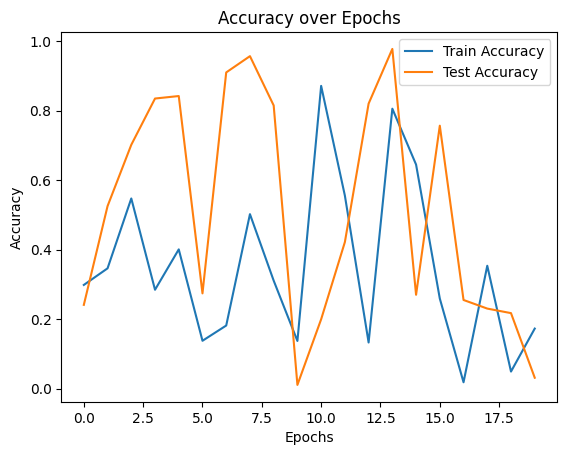

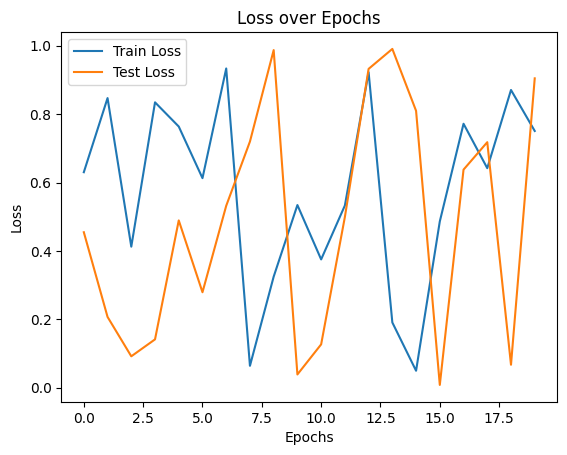

In [ ]:
def train():
    # Testing a training process
    train_acc = np.random.rand()
    train_loss = np.random.rand()
    return train_loss, train_acc

def test():
    # Testing a testing process
    test_acc = np.random.rand()
    test_loss = np.random.rand()
    return test_loss, test_acc

def epoch_loop():
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(args.epochs):
        train_loss, train_acc = train()
        test_loss, test_acc = test()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Plot metrics after all epochs
    plot_metrics(train_accuracies, test_accuracies, "Accuracy")
    plot_metrics(train_losses, test_losses, "Loss")

# Run the mock epoch loop
epoch_loop()

## 3. ReviewKD++

Code Link: https://github.com/WangYZ1608/Knowledge-Distillation-via-ND/blob/main/CIFAR/ReviewKD%2B%2B/train_reviewkd.py

In [1]:
!pip install torchsummaryX --quiet

In [3]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchsummaryX import summary
import logging
import time
import random
import warnings
from pathlib import Path
import numpy as np
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
import os
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F

import torchvision.models as Models
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from utils import colorstr, Save_Checkpoint, AverageMeter, DirectNormLoss
logger = logging.getLogger()



In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170498071/170498071 [00:02<00:00, 71600522.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
teacher = torchvision.models.resnet18(pretrained=True)
teacher.fc = nn.Linear(teacher.fc.in_features, 10)

student = torchvision.models.resnet34(pretrained=False)
student.fc = nn.Linear(student.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#### Input - Hyperparameters
# from github https://github.com/WangYZ1608/Knowledge-Distillation-via-ND/tree/main/CIFAR

epochs = 20
batch_size = 64
lr = 0.1
momentum = 0.9
weight_decay = 5e-4
kd_loss_factor = 5.0
cls_loss_factor = 1.0
nd_loss_factor = 4.0

In [ ]:
#### Input - Hyperparameters
epochs = 20
batch_size = 64
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
kd_loss_factor = 0.1

In [ ]:
#### Best trial: lr 0.04887146612242114, momentum 0.7826219116359754, weight_decay 1.0573054488478825e-05, kd_loss_factor 0.4997783417046702
#### Input - Hyperparameters
epochs = 20
batch_size = 64
lr = 0.04887146612242114
momentum = 0.7826219116359754
weight_decay = 1.0573054488478825e-05
kd_loss_factor = 0.4997783417046702

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
optimizer = optim.SGD(student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
#### HCL loss - L2 distance between features
def hcl(student_features, teacher_features):
    return F.mse_loss(student_features, teacher_features)

In [ ]:
def train(student, teacher, dataloader, criterion, optimizer):

    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    student.train()
    teacher.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Get student outputs and features
        student_outputs = student(images)
        _, student_preds = student_outputs.max(1)

        # Get teacher outputs and features with no gradients
        with torch.no_grad():
            teacher_outputs = teacher(images)

        # Calculate losses
        classification_loss = criterion(student_outputs, labels)
        distillation_loss = hcl(student_outputs, teacher_outputs)

        # # cls loss
        # cls_loss = criterion(s_logits, labels) * cls_loss_factor
        # # Kd loss
        # kd_loss = hcl(s_features, t_features) * min(1, epoch/args.warm_up) * args.kd_loss_factor
        # # ND loss
        # norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        # loss = cls_loss + kd_loss + norm_dir_loss


        # loss = classification_loss + kd_loss_factor * distillation_loss
        loss = cls_loss_factor * classification_loss + kd_loss_factor * distillation_loss # + nd_loss_factor * nd_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += student_preds.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
def test(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(1)

            total_loss += loss.item()
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
for epoch in range(epochs):
    train_loss, train_accuracy = train(student, teacher, train_loader, criterion, optimizer)
    test_loss, test_accuracy = test(student, test_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Epoch 1/20, Train Loss: nan, Train Acc: 9.9760, Test Loss: nan, Test Acc: 10.0000
Epoch 2/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 3/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 4/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 5/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 6/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 7/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 8/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 9/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 10/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 11/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Epoch 12/20, Train Loss: nan, Train Acc: 10.0000, Test Loss: nan, Test Acc: 10.0000
Ep

-------------------------

# START HERE

__GITHUB__

https://github.com/WangYZ1608/Knowledge-Distillation-via-ND/tree/main/CIFAR/ReviewKD%2B%2B

Teacher Weight: https://github.com/megvii-research/mdistiller/releases/tag/checkpoints

In [ ]:
!pip install torchsummaryX --quiet

In [14]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import models
from models.reviewkd import build_review_kd, hcl
# from Dataset import CIFAR
from utils import colorstr, Save_Checkpoint, AverageMeter, DirectNormLoss
from torchsummaryX import summary

import numpy as np
import time
import json
import random
import warnings
from torch.utils.tensorboard import SummaryWriter

### need to clean up
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchsummaryX import summary
import logging
import time
import random
import warnings
from pathlib import Path
import numpy as np
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as Models
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [34]:

# Setting up parameters
class Args:
    model_name = "resnet20_cifar"
    dataset = 'cifar10'
    epochs = 20 # 240
    batch_size = 64  # 128
    workers = 8
    lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    teacher = "resnet56_cifar"
    teacher_weights = "ckpt_epoch_240.pth" # for resnet56_cifar
    cls_loss_factor = 1.0
    kd_loss_factor = 1.0
    nd_loss_factor = 1.0
    warm_up = 20.0
    gpus = [0, 1]
    seed = None
    resume = None
    save_dir = "./run"

args = Args()

In [26]:
# python3 train_reviewkd.py \
#     --model_name wrn40_1_cifar \
#     --teacher wrn40_2_cifar \
#     --teacher_weights 'Teacher WEIGHT PATH' \
#     --dataset 'cifar100' \
#     --epoch 240 \
#     --batch_size 64 \
#     --lr 0.1 \
#     --cls_loss_factor 1.0 \
#     --kd_loss_factor 5.0 \
#     --nd_loss_factor 4.0 \
#     --save_dir "./run/CIFAR100/ReviewKD++/res32X4-SV2"

In [16]:
def CIFAR10_data():
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
    num_class = 10
    return train_set, test_set, num_class

# CIFAR data loading part
if args.dataset == 'cifar10':
    train_set, test_set, num_class = CIFAR10_data()
elif args.dataset == 'cifar100': # hasnt set up this yet
    pass
else:
    print("No Dataset!")

Files already downloaded and verified
Files already downloaded and verified


In [37]:
def train(model, teacher, T_EMB, train_dataloader, optimizer, criterion, nd_loss, args, epoch):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    # Model on train mode
    model.train()
    teacher.eval()
    step_per_epoch = len(train_dataloader)

    # pdb.set_trace()
    for step, (images, labels) in enumerate(train_dataloader):
        start = time.time()
        images, labels = images.cuda(), labels.cuda()

        # compute output
        s_features, s_emb, s_logits = model(images)

        with torch.no_grad():
            t_features, t_emb, t_logits = teacher(images, is_feat=True, preact=True)
            t_features = t_features[1:]

        # cls loss
        cls_loss = criterion(s_logits, labels) * args.cls_loss_factor
        # Kd loss
        kd_loss = hcl(s_features, t_features) * min(1, epoch/args.warm_up) * args.kd_loss_factor
        # ND loss
        norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        loss = cls_loss + kd_loss + norm_dir_loss
        # measure accuracy and record loss
        batch_size = images.size(0)
        _, pred = s_logits.data.cpu().topk(1, dim=1)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        Cls_loss.update(cls_loss.item(), batch_size)
        Div_loss.update(kd_loss.item(), batch_size)
        Norm_Dir_loss.update(norm_dir_loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
        s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - div_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
             1000 * (time.time() - start), norm_dir_loss.item(), kd_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)

        print(s1+s2, end='', flush=True)

    print()
    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg


def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    # Model on eval mode
    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()

            # compute logits
            _, _, logits = model(images)

            loss = criterion(logits, labels)

            # measure accuracy and record loss
            batch_size = images.size(0)
            _, pred = logits.data.cpu().topk(1, dim=1)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg


def epoch_loop(model, teacher, train_set, test_set, args):
    # data loaders
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.workers)

    # model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.DataParallel(model, device_ids=args.gpus)
    model.to(device)
    teacher = nn.DataParallel(teacher, device_ids=args.gpus)
    teacher.to(device)

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    nd_loss = DirectNormLoss(num_class=10, nd_loss_factor=args.nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)

    # 权重
    save_dir = Path(args.save_dir)
    weights = save_dir / 'weights'
    weights.mkdir(parents=True, exist_ok=True)
    last = weights / 'last'
    best = weights / 'best'

    # acc,loss
    acc_loss = save_dir / 'acc_loss'
    acc_loss.mkdir(parents=True, exist_ok=True)

    train_acc_savepath = acc_loss / 'train_acc.npy'
    train_loss_savepath = acc_loss / 'train_loss.npy'
    val_acc_savepath = acc_loss / 'val_acc.npy'
    val_loss_savepath = acc_loss / 'val_loss.npy'

    # tensorboard
    logdir = save_dir / 'logs'
    logdir.mkdir(parents=True, exist_ok=True)
    summary_writer = SummaryWriter(logdir, flush_secs=120)

    # resume
    if args.resume:
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_error = checkpoint['best_error']
        train_acc = checkpoint['train_acc']
        train_loss = checkpoint['train_loss']
        test_acc = checkpoint['test_acc']
        test_loss = checkpoint['test_loss']
        logger.info(colorstr('green', 'Resuming training from {} epoch'.format(start_epoch)))
    else:
        start_epoch = 0
        best_error = 0
        train_acc = []
        train_loss = []
        test_acc = []
        test_loss = []

    # Train model
    best_error = 1
    for epoch in range(start_epoch, args.epochs):
        if epoch in [150, 180, 210]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        print("Epoch {}/{}".format(epoch + 1, args.epochs))
        norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error = train(model=model,
                                                                                 teacher=teacher,
                                                                                 T_EMB=T_EMB,
                                                                                 train_dataloader=train_loader,
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion,
                                                                                 nd_loss=nd_loss,
                                                                                 args=args,
                                                                                 epoch=epoch)
        test_epoch_loss, test_error = test(model=model,
                                           test_dataloader=test_loader,
                                           criterion=criterion)

        s = "Train Loss: {:.3f}, Train Acc: {:.3f}, Test Loss: {:.3f}, Test Acc: {:.3f}, lr: {:.5f}".format(
            train_epoch_loss, 1-train_error, test_epoch_loss, 1-test_error, optimizer.param_groups[0]['lr'])
        logger.info(colorstr('green', s))

        # save acc,loss
        train_loss.append(train_epoch_loss)
        train_acc.append(1-train_error)
        test_loss.append(test_epoch_loss)
        test_acc.append(1-test_error)

        # save model
        is_best = test_error < best_error
        best_error = min(best_error, test_error)
        state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_error': best_error,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss,
            }

        last_path = last / 'epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(
            epoch + 1, test_epoch_loss, 1-test_error)
        best_path = best / 'epoch_{}_acc_{:.3f}'.format(
                epoch + 1, 1-best_error)

        Save_Checkpoint(state, last, last_path, best, best_path, is_best)

        # tensorboard
        # pdb.set_trace()
        if epoch == 1:
            images, labels = next(iter(train_loader))
            img_grid = torchvision.utils.make_grid(images)
            summary_writer.add_image('Cifar Image', img_grid)
        summary_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        summary_writer.add_scalar('train_loss', train_epoch_loss, epoch)
        summary_writer.add_scalar('train_error', train_error, epoch)
        summary_writer.add_scalar('val_loss', test_epoch_loss, epoch)
        summary_writer.add_scalar('val_error', test_error, epoch)

        summary_writer.add_scalar('nd_loss', norm_dir_loss, epoch)
        summary_writer.add_scalar('kd_loss', div_loss, epoch)
        summary_writer.add_scalar('cls_loss', cls_loss, epoch)

    summary_writer.close()
    if not os.path.exists(train_acc_savepath) or not os.path.exists(train_loss_savepath):
        np.save(train_acc_savepath, train_acc)
        np.save(train_loss_savepath, train_loss)
        np.save(val_acc_savepath, test_acc)
        np.save(val_loss_savepath, test_loss)


In [38]:
with open("center_emb_train.json", 'r') as f:
    T_EMB = json.load(f)
f.close()

In [39]:
# Load weights into a temporary variable
teacher_ckpt = torch.load(args.teacher_weights)['model']

# Remove fc keys
teacher_ckpt = {k: v for k, v in teacher_ckpt.items() if not k.startswith('fc.')}

# Now, load the state dict into the model, ignoring the fc layer
teacher.load_state_dict(teacher_ckpt, strict=False)


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [40]:
# if args.teacher_weights:
#   print('Load Teacher Weights')
#   teacher_ckpt = torch.load(args.teacher_weights)['model']
#   teacher.load_state_dict(teacher_ckpt)

#   for param in teacher.parameters():
#       param.requires_grad = False

In [41]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
args.gpus = [0]

True
1


In [42]:
model = build_review_kd(student_name=args.model_name, num_class=num_class, teacher_name=args.teacher)
model.to(device)
teacher = models.__dict__[args.teacher](num_class=num_class)

epoch_loop(model=model, teacher=teacher, train_set=train_set, test_set=test_set, args=args)


Epoch 1/20
2023-10-19 12:24:40 [782/782] - 37.76ms/step - nd_loss: 1.000 - div_loss: 0.000 - cls_loss: 1.442 - train_loss: 2.442 - train_acc: 0.438
Epoch 2/20
2023-10-19 12:25:35 [782/782] - 34.19ms/step - nd_loss: 0.999 - div_loss: 70546.117 - cls_loss: 31.577 - train_loss: 70578.695 - train_acc: 0.188
Epoch 3/20
2023-10-19 12:26:30 [782/782] - 32.66ms/step - nd_loss: 0.998 - div_loss: 23335.311 - cls_loss: 389.468 - train_loss: 23725.775 - train_acc: 0.125
Epoch 4/20
2023-10-19 12:27:25 [782/782] - 34.46ms/step - nd_loss: 0.996 - div_loss: 84095.789 - cls_loss: 1934.271 - train_loss: 86031.055 - train_acc: 0.188
Epoch 5/20
2023-10-19 12:28:19 [782/782] - 36.74ms/step - nd_loss: 0.999 - div_loss: 62873.207 - cls_loss: 110.563 - train_loss: 62984.770 - train_acc: 0.062
Epoch 6/20
2023-10-19 12:29:13 [782/782] - 33.42ms/step - nd_loss: 0.992 - div_loss: 120966.812 - cls_loss: 48887.285 - train_loss: 169855.078 - train_acc: 0.125
Epoch 7/20
2023-10-19 12:30:07 [782/782] - 36.66ms/step - 

In [ ]:
########################## Add More Metrics: F1, Recall, Precision, etc.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt


In [43]:
def train(model, teacher, T_EMB, train_dataloader, optimizer, criterion, nd_loss, args, epoch):
    train_loss = AverageMeter()
    train_error = AverageMeter()
    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    train_labels = []
    train_preds = []

    # Model on train mode
    model.train()
    teacher.eval()
    step_per_epoch = len(train_dataloader)

    for step, (images, labels) in enumerate(train_dataloader):
        start = time.time()
        images, labels = images.cuda(), labels.cuda()

        # compute output
        s_features, s_emb, s_logits = model(images)

        with torch.no_grad():
            t_features, t_emb, t_logits = teacher(images, is_feat=True, preact=True)
            t_features = t_features[1:]

        # cls loss
        cls_loss = criterion(s_logits, labels) * args.cls_loss_factor
        # Kd loss
        kd_loss = hcl(s_features, t_features) * min(1, epoch/args.warm_up) * args.kd_loss_factor
        # ND loss
        norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        loss = cls_loss + kd_loss + norm_dir_loss

        _, pred = s_logits.data.cpu().topk(1, dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(pred.squeeze().numpy())

        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / images.size(0), images.size(0))
        train_loss.update(loss.item(), images.size(0))
        Cls_loss.update(cls_loss.item(), images.size(0))
        Div_loss.update(kd_loss.item(), images.size(0))
        Norm_Dir_loss.update(norm_dir_loss.item(), images.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
        s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - div_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
             1000 * (time.time() - start), norm_dir_loss.item(), kd_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)

        print(s1+s2, end='', flush=True)

    print()

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_precision = precision_score(train_labels, train_preds, average='macro')
    train_recall = recall_score(train_labels, train_preds, average='macro')
    train_accuracy = accuracy_score(train_labels, train_preds)

    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg, train_f1, train_precision, train_recall, train_accuracy

def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    test_labels = []
    test_preds = []

    # Model on eval mode
    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()
            _, _, logits = model(images)
            loss = criterion(logits, labels)

            _, pred = logits.data.cpu().topk(1, dim=1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(pred.squeeze().numpy())

            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / images.size(0), images.size(0))
            test_loss.update(loss.item(), images.size(0))

    test_f1 = f1_score(test_labels, test_preds, average='macro')
    test_precision = precision_score(test_labels, test_preds, average='macro')
    test_recall = recall_score(test_labels, test_preds, average='macro')
    test_accuracy = accuracy_score(test_labels, test_preds)

    return test_loss.avg, test_error.avg, test_f1, test_precision, test_recall, test_accuracy


In [46]:
train_f1_list, train_precision_list, train_recall_list, train_accuracy_list = [], [], [], []
test_f1_list, test_precision_list, test_recall_list, test_accuracy_list = [], [], [], []


for epoch in range(args.epochs):

    # Adjust parameters
    if epoch in [150, 180, 210]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    print("Epoch {}/{}".format(epoch + 1, args.epochs))

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    nd_loss = DirectNormLoss(num_class=10, nd_loss_factor=args.nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)

    # train function
    norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error, train_f1, train_precision, train_recall, train_accuracy = train(
        model=model,
        teacher=teacher,
        T_EMB=T_EMB,
        train_dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        nd_loss=nd_loss,
        args=args,
        epoch=epoch
    )

    # test function
    test_epoch_loss, test_error, test_f1, test_precision, test_recall, test_accuracy = test(
        model=model,
        test_dataloader=test_loader,
        criterion=criterion
    )

    # Append the metrics to their respective lists
    train_f1_list.append(train_f1)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_accuracy_list.append(train_accuracy)
    test_f1_list.append(test_f1)
    test_precision_list.append(test_precision)
    test_recall_list.append(test_recall)
    test_accuracy_list.append(test_accuracy)

    # Display metrics, save model, or perform other operations as necessary
    s = (
        f"Epoch {epoch + 1} - Train Loss: {train_epoch_loss:.3f}, Train Acc: {1-train_error:.3f}, "
        f"Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}, "
        f"Test Loss: {test_epoch_loss:.3f}, Test Acc: {1-test_error:.3f}, "
        f"Test F1: {test_f1:.3f}, Test Precision: {test_precision:.3f}, Test Recall: {test_recall:.3f}"
    )
    print(s)

    # Optionally save checkpoints or perform other operations here


Epoch 1/20
2023-10-19 12:57:49 [782/782] - 32.01ms/step - nd_loss: 0.992 - div_loss: 0.000 - cls_loss: 13016.741 - train_loss: 13017.733 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 - Train Loss: 11544.538, Train Acc: 0.104, Train F1: 0.028, Train Precision: 0.057, Train Recall: 0.104, Test Loss: 11572.642, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.060, Test Recall: 0.103
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 12:58:44 [782/782] - 33.07ms/step - nd_loss: 0.991 - div_loss: 5840.867 - cls_loss: 13930.596 - train_loss: 19772.453 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 - Train Loss: 18130.842, Train Acc: 0.103, Train F1: 0.027, Train Precision: 0.046, Train Recall: 0.103, Test Loss: 11454.031, Test Acc: 0.103, Test F1: 0.027, Test Precision: 0.060, Test Recall: 0.103
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 12:59:38 [782/782] - 36.26ms/step - nd_loss: 0.991 - div_loss: 10998.909 - cls_loss: 9627.593 - train_loss: 20627.492 - train_acc: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 - Train Loss: 24659.572, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.054, Train Recall: 0.104, Test Loss: 11557.803, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.053, Test Recall: 0.103
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:00:32 [782/782] - 34.52ms/step - nd_loss: 0.991 - div_loss: 20758.086 - cls_loss: 10044.220 - train_loss: 30803.295 - train_acc: 0.250


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4 - Train Loss: 31304.871, Train Acc: 0.103, Train F1: 0.027, Train Precision: 0.054, Train Recall: 0.103, Test Loss: 11392.192, Test Acc: 0.104, Test F1: 0.028, Test Precision: 0.085, Test Recall: 0.103
Epoch 5/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:01:26 [782/782] - 34.16ms/step - nd_loss: 0.991 - div_loss: 25240.654 - cls_loss: 11794.669 - train_loss: 37036.316 - train_acc: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5 - Train Loss: 37943.220, Train Acc: 0.103, Train F1: 0.027, Train Precision: 0.055, Train Recall: 0.103, Test Loss: 11490.272, Test Acc: 0.103, Test F1: 0.027, Test Precision: 0.036, Test Recall: 0.103
Epoch 6/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:02:20 [782/782] - 33.14ms/step - nd_loss: 0.991 - div_loss: 35591.445 - cls_loss: 14035.014 - train_loss: 49627.453 - train_acc: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6 - Train Loss: 44463.360, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.046, Train Recall: 0.104, Test Loss: 11455.153, Test Acc: 0.102, Test F1: 0.026, Test Precision: 0.037, Test Recall: 0.102
Epoch 7/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:03:15 [782/782] - 34.26ms/step - nd_loss: 0.990 - div_loss: 55409.523 - cls_loss: 10795.071 - train_loss: 66205.586 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7 - Train Loss: 51167.622, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.050, Train Recall: 0.104, Test Loss: 11469.852, Test Acc: 0.102, Test F1: 0.026, Test Precision: 0.076, Test Recall: 0.102
Epoch 8/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:04:09 [782/782] - 31.37ms/step - nd_loss: 0.991 - div_loss: 38135.109 - cls_loss: 15674.736 - train_loss: 53810.836 - train_acc: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8 - Train Loss: 57626.631, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.063, Train Recall: 0.104, Test Loss: 11587.288, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.030, Test Recall: 0.103
Epoch 9/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:05:03 [782/782] - 32.67ms/step - nd_loss: 0.991 - div_loss: 50394.586 - cls_loss: 12893.978 - train_loss: 63289.555 - train_acc: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9 - Train Loss: 64288.565, Train Acc: 0.103, Train F1: 0.027, Train Precision: 0.057, Train Recall: 0.103, Test Loss: 11426.220, Test Acc: 0.103, Test F1: 0.027, Test Precision: 0.063, Test Recall: 0.103
Epoch 10/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:05:57 [782/782] - 32.38ms/step - nd_loss: 0.990 - div_loss: 52545.137 - cls_loss: 10697.035 - train_loss: 63243.160 - train_acc: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10 - Train Loss: 70950.098, Train Acc: 0.103, Train F1: 0.027, Train Precision: 0.051, Train Recall: 0.103, Test Loss: 11520.144, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.041, Test Recall: 0.103
Epoch 11/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:06:51 [782/782] - 34.53ms/step - nd_loss: 0.991 - div_loss: 79542.125 - cls_loss: 13551.660 - train_loss: 93094.773 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11 - Train Loss: 77532.547, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.054, Train Recall: 0.104, Test Loss: 11420.819, Test Acc: 0.103, Test F1: 0.027, Test Precision: 0.056, Test Recall: 0.103
Epoch 12/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:07:45 [782/782] - 32.11ms/step - nd_loss: 0.991 - div_loss: 87046.055 - cls_loss: 12267.414 - train_loss: 99314.461 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12 - Train Loss: 83900.393, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.060, Train Recall: 0.104, Test Loss: 11637.688, Test Acc: 0.102, Test F1: 0.025, Test Precision: 0.094, Test Recall: 0.102
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:08:39 [782/782] - 32.53ms/step - nd_loss: 0.992 - div_loss: 94445.289 - cls_loss: 10122.044 - train_loss: 104568.328 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13 - Train Loss: 90446.087, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.049, Train Recall: 0.104, Test Loss: 11602.904, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.076, Test Recall: 0.102
Epoch 14/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:09:34 [782/782] - 31.81ms/step - nd_loss: 0.992 - div_loss: 114533.867 - cls_loss: 14962.743 - train_loss: 129497.602 - train_acc: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14 - Train Loss: 97288.305, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.045, Train Recall: 0.104, Test Loss: 11656.196, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.049, Test Recall: 0.102
Epoch 15/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:10:28 [782/782] - 33.24ms/step - nd_loss: 0.991 - div_loss: 83787.359 - cls_loss: 10546.329 - train_loss: 94334.680 - train_acc: 0.188


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15 - Train Loss: 103525.315, Train Acc: 0.104, Train F1: 0.028, Train Precision: 0.054, Train Recall: 0.104, Test Loss: 11559.285, Test Acc: 0.102, Test F1: 0.026, Test Precision: 0.047, Test Recall: 0.102
Epoch 16/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:11:22 [782/782] - 32.09ms/step - nd_loss: 0.991 - div_loss: 124655.672 - cls_loss: 11658.664 - train_loss: 136315.328 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16 - Train Loss: 110765.857, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.054, Train Recall: 0.104, Test Loss: 11487.512, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.066, Test Recall: 0.102
Epoch 17/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:12:17 [782/782] - 34.15ms/step - nd_loss: 0.992 - div_loss: 105241.203 - cls_loss: 13328.431 - train_loss: 118570.625 - train_acc: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17 - Train Loss: 116893.214, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.052, Train Recall: 0.104, Test Loss: 11526.011, Test Acc: 0.102, Test F1: 0.026, Test Precision: 0.084, Test Recall: 0.102
Epoch 18/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:13:11 [782/782] - 32.91ms/step - nd_loss: 0.991 - div_loss: 100868.039 - cls_loss: 11306.781 - train_loss: 112175.812 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18 - Train Loss: 122937.211, Train Acc: 0.104, Train F1: 0.027, Train Precision: 0.050, Train Recall: 0.104, Test Loss: 11499.893, Test Acc: 0.103, Test F1: 0.026, Test Precision: 0.038, Test Recall: 0.103
Epoch 19/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:14:05 [782/782] - 32.04ms/step - nd_loss: 0.991 - div_loss: 145805.984 - cls_loss: 12336.572 - train_loss: 158143.547 - train_acc: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19 - Train Loss: 130503.190, Train Acc: 0.104, Train F1: 0.028, Train Precision: 0.067, Train Recall: 0.104, Test Loss: 11507.278, Test Acc: 0.102, Test F1: 0.026, Test Precision: 0.039, Test Recall: 0.102
Epoch 20/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-10-19 13:14:59 [782/782] - 31.47ms/step - nd_loss: 0.991 - div_loss: 95987.242 - cls_loss: 10093.284 - train_loss: 106081.516 - train_acc: 0.062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20 - Train Loss: 136617.606, Train Acc: 0.104, Train F1: 0.028, Train Precision: 0.059, Train Recall: 0.104, Test Loss: 11471.849, Test Acc: 0.103, Test F1: 0.028, Test Precision: 0.055, Test Recall: 0.103


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


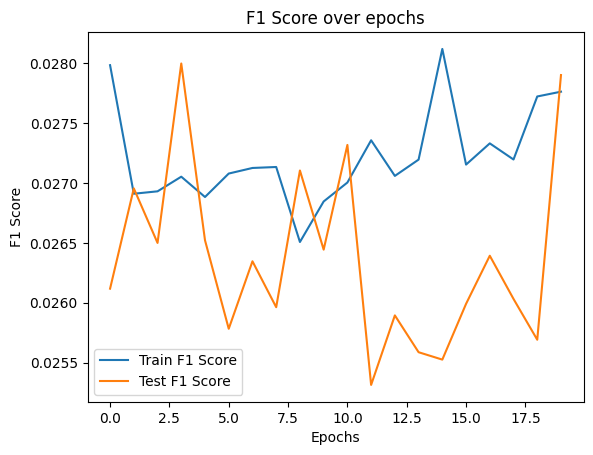

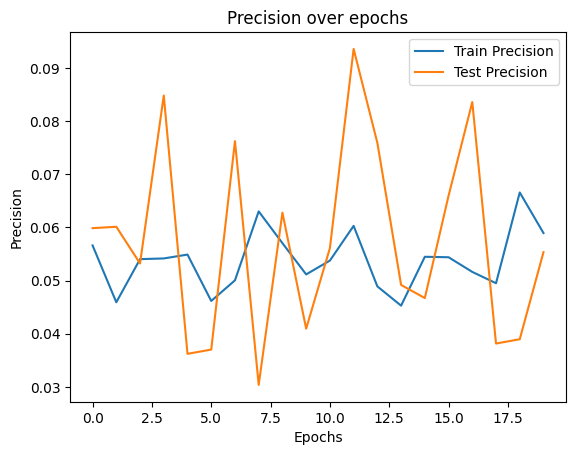

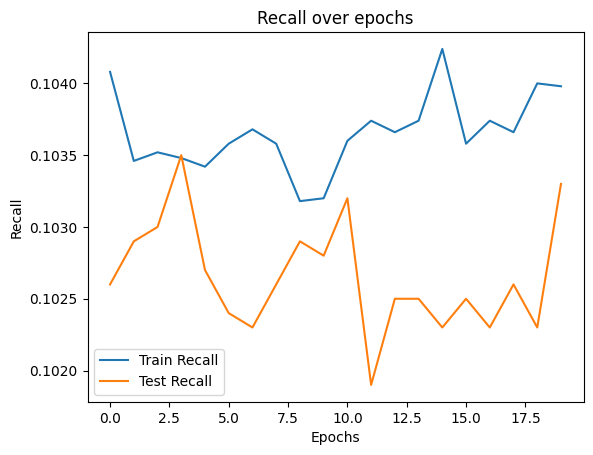

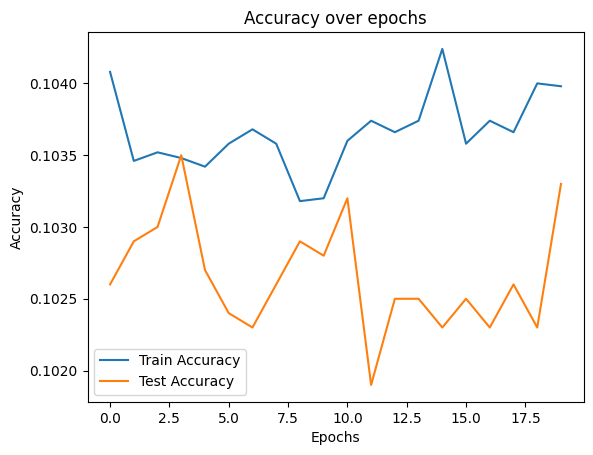

In [47]:
# Plotting function
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(test_metrics, label=f"Test {metric_name}")
    plt.legend()
    plt.title(f"{metric_name} over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

# After your epoch loop, plot the metrics:
plot_metrics(train_f1_list, test_f1_list, "F1 Score")
plot_metrics(train_precision_list, test_precision_list, "Precision")
plot_metrics(train_recall_list, test_recall_list, "Recall")
plot_metrics(train_accuracy_list, test_accuracy_list, "Accuracy")


In [29]:
!pip install torchsummary
!pip install scikit-learn

In [30]:
# Additional Library
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [31]:
# def get_metrics(true, pred):
#     precision = precision_score(true, pred, average="macro")
#     recall = recall_score(true, pred, average="macro")
#     f1 = f1_score(true, pred, average="macro")
#     return precision, recall, f1

def multiclass_auc(labels, preds):
    # convert labels to one-hot encoding
    one_hot = np.eye(10)[labels]
    return roc_auc_score(one_hot, preds, multi_class='ovr')

def get_metrics(true, pred):
    precision = precision_score(true, pred, average='weighted')  # weighted: multi-class data
    recall = recall_score(true, pred, average='weighted')
    f1 = f1_score(true, pred, average='weighted')
    return precision, recall, f1


In [36]:

all_train_acc, all_test_acc = [], []
all_train_f1, all_test_f1 = [], []

for epoch in range(epochs):

    train_loss, train_accuracy = train(student, teacher, train_loader, criterion, optimizer)
    test_loss, test_accuracy = test(student, test_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    all_train_acc.append(train_accuracy)
    all_test_acc.append(test_accuracy)

    # precision, recall, F1 for training data
    train_true, train_pred = [], []
    student.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student(images)
            _, preds = outputs.max(1)
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(preds.cpu().numpy())
    precision, recall, f1 = get_metrics(train_true, train_pred)
    all_train_f1.append(f1)


    print(f"Training - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # precision, recall, F1 for test data
    test_true, test_pred, test_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)



TypeError: ignored

In [ ]:

all_train_acc, all_test_acc = [], []
all_train_f1, all_test_f1 = [], []

for epoch in range(epochs):

    # For Training
    train_loss, train_accuracy = train(student, teacher, train_loader, criterion, optimizer)
    test_loss, test_accuracy = test(student, test_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    all_train_acc.append(train_accuracy)
    all_test_acc.append(test_accuracy)

    train_true, train_pred = [], []
    student.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student(images)
            _, preds = outputs.max(1)
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(preds.cpu().numpy())

    precision, recall, f1 = get_metrics(train_true, train_pred)
    all_train_f1.append(f1)
    print(f"Training - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # For Test
    test_true, test_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student(images)
            _, preds = outputs.max(1)
            test_true.extend(labels.cpu().numpy())
            test_pred.extend(preds.cpu().numpy())

    precision, recall, f1 = get_metrics(test_true, test_pred)
    all_test_f1.append(f1)
    print(f"Test - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


In [ ]:
# plots
epochs_range = range(1, epochs+1)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, all_train_acc, label="Train Accuracy")
plt.plot(epochs_range, all_test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, all_train_f1, label="Train F1 Score")
plt.plot(epochs_range, all_test_f1, label="Test F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


----------------------------------

__DO NOT RUN THE CODE BELOEW__

In [ ]:
### hypyter tuning test

In [ ]:
!pip install optuna --quiet

import optuna

In [ ]:
def objective(trial):
    # hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    kd_loss_factor = trial.suggest_uniform('kd_loss_factor', 0.05, 0.5)

    # Create a new student model
    student = torchvision.models.resnet34(pretrained=False)
    student.fc = nn.Linear(student.fc.in_features, 10)
    student.to(device)

    # Initialize optimizer
    optimizer = optim.SGD(student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    for epoch in range(epochs):
        train_loss, train_accuracy = train(student, teacher, train_loader, criterion, optimizer)

    _, test_accuracy = test(student, test_loader, criterion)

    return test_accuracy


In [ ]:
study = optuna.create_study(direction="maximize")  # Maximize the accuracy
study.optimize(objective, n_trials=50)

print(f"Best trial: lr {study.best_params['lr']}, momentum {study.best_params['momentum']}, weight_decay {study.best_params['weight_decay']}, kd_loss_factor {study.best_params['kd_loss_factor']}")


[I 2023-10-16 13:57:16,068] A new study created in memory with name: no-name-94572f20-f720-49ce-8021-9921121e32ab
<ipython-input-48-96e2f2d8a19f>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-48-96e2f2d8a19f>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
<ipython-input-48-96e2f2d8a19f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
<ipyth

Best trial: lr 0.04887146612242114, momentum 0.7826219116359754, weight_decay 1.0573054488478825e-05, kd_loss_factor 0.4997783417046702


In [ ]:
# %load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# %tensorboard --logdir ./run/logs


Reusing TensorBoard on port 6006 (pid 6905), started 0:27:37 ago. (Use '!kill 6905' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# !pip freeze > requirements.txt
